In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import pytz
from pytz import timezone
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tz = timezone('US/Central') # This data uses GMT-6 rather than standard CST/CDT
def toUTC(d):
    return tz.normalize(tz.localize(d)).astimezone(pytz.utc)

In [3]:
def string2datetime(stringDTSeries):
    try:
        return [(dt.datetime.strptime(DT,'%Y/%m/%d %I:%M:%S %p')) for DT in stringDTSeries]
    except(ValueError):
        try:
            return [(dt.datetime.strptime(DT,'%Y/%m/%d %H:%M:%S')) for DT in stringDTSeries]
        except(ValueError):
            try:
                return [(dt.datetime.strptime(DT,'%m/%d/%Y %I:%M:%S %p')) for DT in stringDTSeries]
            except(ValueError):
                try:
                    return [(dt.datetime.strptime(DT,'%m/%d/%Y %H:%M:%S')) for DT in stringDTSeries]
                except(ValueError):
                    return [(dt.datetime.strptime(DT,'%m/%d/%y %H:%M:%S')) for DT in stringDTSeries]

In [4]:
# path = '/Volumes/RT&O/C Brace/GPS Analysis/' #mac
path = 'X:/C Brace/GPS Analysis/' #win


## Add LandUse coordinates and weartime to UIC preprocessed GPS files

In [15]:
Baseline = pd.read_excel(path+'/UIC_GPSData/CBR15_Final_Summary_File.xlsx')

In [16]:
Baseline.LandUse.unique()

array(['trip', 'COM_URBMIX', 'home', 'RES_SF_DETACHED', 'COM_CULT_ENT',
       'OS_REC', 'Non-Parcel Road ROW', 'TCU_PARKING', 'COM_REGIONAL',
       'COM_OFFICE', 'RES_MF', 'COM_BIGBOX', 'COM_MALL', 'COM_HOTEL',
       'INST_MEDICAL'], dtype=object)

In [17]:
Gpsdata = pd.read_csv(path+'GPSWT/CBR15_Baseline.csv')

In [28]:
Baseline.head(3)

,Date,Sequence,BeginTime,EndTime,Mode,LandUse,MeanSpeed,Numberpoints,TotalGap,Duration
0,2015-07-02,1,11:12:13,12:47:30,Car,trip,77.185558,518,9.116665,95.283333
1,2015-07-02,2,12:47:35,12:54:18,NaN,COM_URBMIX,2.076743,31,1.633333,6.716667
2,2015-07-02,3,12:54:23,13:00:53,Car,trip,33.312281,79,0.000000,6.500000


In [29]:
Gpsdata.head(3)

,Unnamed: 0,INDEX,TRACK ID,VALID,UTC DATE,UTC TIME,LOCAL DATE,LOCAL TIME,MS,LATITUDE,N/S,LONGITUDE,E/W,ALTITUDE,SPEED,HEADING,G-X,G-Y,G-Z,Wear/Non-Wear
0,0,1,1,FIXED,7/2/2015,16:12:13,7/2/2015,10:12:13,0,41.895511,N,87.618302,W,189.558014,0.0,0.0,0,0,0,Wear
1,1,2,1,FIXED,7/2/2015,16:12:14,7/2/2015,10:12:14,0,41.895511,N,87.618302,W,189.558014,0.0,0.0,0,0,0,Wear
2,2,3,1,FIXED,7/2/2015,16:12:15,7/2/2015,10:12:15,0,41.895511,N,87.618302,W,189.558014,0.0,0.0,0,0,0,Wear


In [30]:
x = Gpsdata['UTC DATE']+' '+Gpsdata['UTC TIME'] #full date/time
GpsDates = string2datetime(x) #convert to datetime object
GpsDates=pd.Series(GpsDates)

In [31]:
GpsDates[:10]

0   2015-07-02 16:12:13
1   2015-07-02 16:12:14
2   2015-07-02 16:12:15
3   2015-07-02 16:12:16
4   2015-07-02 16:12:17
5   2015-07-02 16:12:18
6   2015-07-02 16:12:21
7   2015-07-02 17:03:23
8   2015-07-02 17:03:28
9   2015-07-02 17:03:33
dtype: datetime64[ns]

In [61]:
any(ind)

True

In [5]:
#Baseline: UIC Gps preprocessed Data
#GPSdata: raw Gps data with wear time fraction
#GpsDates: datetime object from Gpsdata to match with UIC data
def add_latlonwear(Baseline,Gpsdata,GpsDates):
    loc_lat = []
    loc_lon = []
    wear_frac = []

    for i in range(len(Baseline)):
        start = Baseline.BeginTime[i]
        end = Baseline.EndTime[i]
        d = Baseline.Date[i]
        
        if type(d) != str:
            d = d.strftime('%Y/%m/%d') 
        if type(start) != str:
            start = str(start)
        if type(end) != str:
            end = str(end)
        try:
            startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y/%m/%d %H:%M:%S'))
            enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y/%m/%d %H:%M:%S'))
        except(ValueError):
            try:
                startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%y %H:%M:%S'))
                enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%y %H:%M:%S'))
            except(ValueError):
                try:
                    startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%Y %H:%M:%S'))
                    enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%Y %H:%M:%S'))
                except(ValueError):
                    startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y-%m-%d %H:%M:%S'))
                    enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y-%m-%d %H:%M:%S'))



        ind = (GpsDates >= startdate) & (GpsDates <= enddate)
        meanLat = np.mean(Gpsdata['LATITUDE'][ind])
        meanLon = np.mean(Gpsdata['LONGITUDE'][ind])
        if np.isnan(meanLat) or np.isnan(meanLon):
            print('null found %s'%any(ind))
            print(startdate,enddate)
        loc_lat.append(meanLat)
        loc_lon.append(meanLon)

        wear_ind = (Gpsdata['Wear/Non-Wear']=='Wear') & ind
        wear_frac.append(sum(wear_ind)/sum(ind))

    Baseline['Mean Lat'] = loc_lat
    Baseline['Mean Lon'] = loc_lon
    Baseline['Wear Frac'] = wear_frac


# Loop through files and add Lat, Lon and Wear Time to UIC files

In [7]:
fwt = os.listdir(path+'GPSWT/')
fconv = os.listdir(path+'UIC_GPSData/w_LatLonWear/')

for f in list(set(fwt)-set(fconv)):
    try:
        #load files
        print(f)
        Gpsdata = pd.read_csv(path+'GPSWT/'+f)
        Subjid = f[:5]
        trial = f[6] #cbrace,SCO or baseline
        switcher = {'C':'CBR','S':'SCO','B':'Baseline'}
        UICdata = pd.read_excel(path+'UIC_GPSData/'+Subjid+'_Final_Summary_File.xlsx',sheetname=switcher[trial])
        
        #convert date formats from raw gps
        x = Gpsdata['UTC DATE']+' '+Gpsdata['UTC TIME'] #full date/time
        GpsDates = string2datetime(x) #convert to datetime object
        GpsDates=pd.Series(GpsDates)
                       
#         #match dates and add lat lon and weartime to UIC processed data
        add_latlonwear(UICdata,Gpsdata,GpsDates)
        
#         #save file
        UICdata.to_csv(path+'UIC_GPSData/w_LatLonWear/'+f)
    except(FileNotFoundError):
        print('File not found')

CBR19_CBrace.csv
CBR22_Baseline.csv
null found False
2016-03-10 22:05:33+00:00 2016-03-10 22:43:23+00:00
null found False
2016-03-10 22:43:33+00:00 2016-03-10 22:51:23+00:00


C:\Users\llonini\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in long_scalars


null found False
2016-03-10 22:51:33+00:00 2016-03-10 22:58:43+00:00
CBR21_CBrace.csv


# Load Files and aggregate per brace

In [14]:
d = pd.read_csv(path+'UIC_GPSData/w_LatLonWear/CBR08_CBrace.csv')


In [43]:
d['SubjID'] = 1
c = d.columns
c = c.values
c[:-1]

array(['Date', 'Sequence', 'BeginTime', 'EndTime', 'Mode', 'LandUse',
       'MeanSpeed', 'Numberpoints', 'TotalGap', 'Duration', 'Mean Lat',
       'Mean Lon', 'Wear Frac'], dtype=object)

In [68]:
Data = pd.DataFrame()
for f in os.listdir(path+'UIC_GPSData/w_LatLonWear/'):
#     print(f)
    d = pd.read_csv(os.path.join(path+'UIC_GPSData/w_LatLonWear/',f))
    del d['Unnamed: 0']
    d['SubjID'] = str(f[:5])
    d['Brace'] = str.capitalize(f[6:9])
    Data = pd.concat([Data,d]) #concatenate data from each subj

In [69]:
cols=list((Data.columns).values)
cols.remove('SubjID')
cols.remove('Brace')
Data = Data[['SubjID','Brace']+cols]
Data.head()

,SubjID,Brace,BeginTime,Date,Duration,EndTime,LandUse,MaximumSpeed,Mean Lat,Mean Lon,MeanSpeed,MinimumSpeed,Mode,Numberpoints,Sequence,TotalGap,Wear Frac
0,CBR08,Cbr,11:42:37,2015-02-10,27.35,12:09:58,Trip,NaN,41.870200,87.711023,46.9405,NaN,Car,165,1,0.559999,1.0
1,CBR08,Cbr,12:10:08,2015-02-10,7.16667,12:17:18,COM_URBMIX,NaN,41.830436,87.803025,2.28438,NaN,NaN,44,2,0.146667,1.0
2,CBR08,Cbr,12:17:28,2015-02-10,19,12:36:28,Trip,NaN,41.839046,87.767186,20.0673,NaN,Car,115,3,0.383333,1.0
3,CBR08,Cbr,12:36:38,2015-02-10,9,12:45:38,COM_URBMIX,NaN,41.851519,87.747862,1.56251,NaN,NaN,55,4,0.183333,1.0
4,CBR08,Cbr,12:45:48,2015-02-10,69.3667,13:55:10,Trip,NaN,41.872845,87.685020,26.8295,NaN,Car,379,5,7.603332,1.0


In [85]:
Data.LandUse.value_counts()

trip                     3088
home                     1422
COM_URBMIX                905
COM_REGIONAL              358
RES_SF_DETACHED           283
Car                       247
RES_MF                    191
Trip                      167
Home                      159
Non-Parcel Road ROW       121
COM_BIGBOX                 91
COM_OFFICE                 89
INST_MEDICAL               65
OS_CONS                    54
INST_RELIGIOUS             42
TRIP                       41
RES_SF_ATTACHED            35
IND_GENERAL                33
INST_GOVT                  32
INST_EDU_HIGHER            25
COM_URBMIXwRES             23
COM_MALL                   15
COM_HOTEL                  15
COM_CULT_ENT               14
VACANT_COM                 14
OS_REC                     11
INST_EDU_K12               10
CONST_COM                   7
OS_GOLF                     7
TCU_AIR                     7
TCU_PARKING                 6
TCU_OTH_LINEAR              4
RES_COMMON                  4
CONST_OTHE

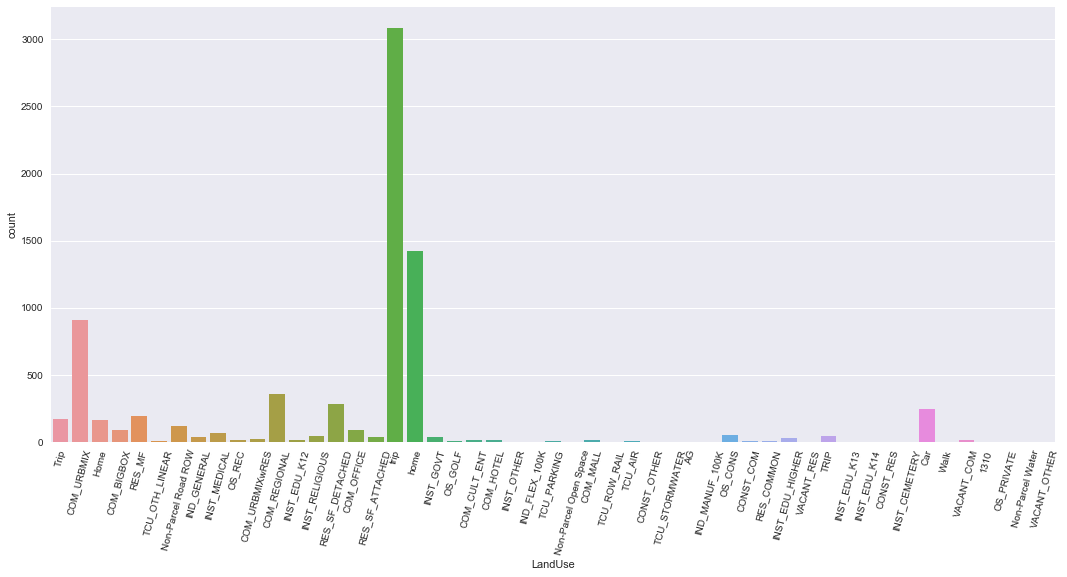

In [82]:
plt.figure(figsize=(18,8))
ax = sns.countplot(Data.LandUse)
ax = plt.xticks(rotation=75)